<a href="https://colab.research.google.com/github/amatrhr/gitmisc/blob/master/mccallmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quantecon

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)
import numpy as np
from numba import jit, float64
from numba.experimental import jitclass
import quantecon as qe
from quantecon.distributions import BetaBinomial
from scipy.stats import norm
from itertools import starmap



In [3]:
n, a, b = 50, 200, 100
q_default = BetaBinomial(n,a,b).pdf()


In [4]:
w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)


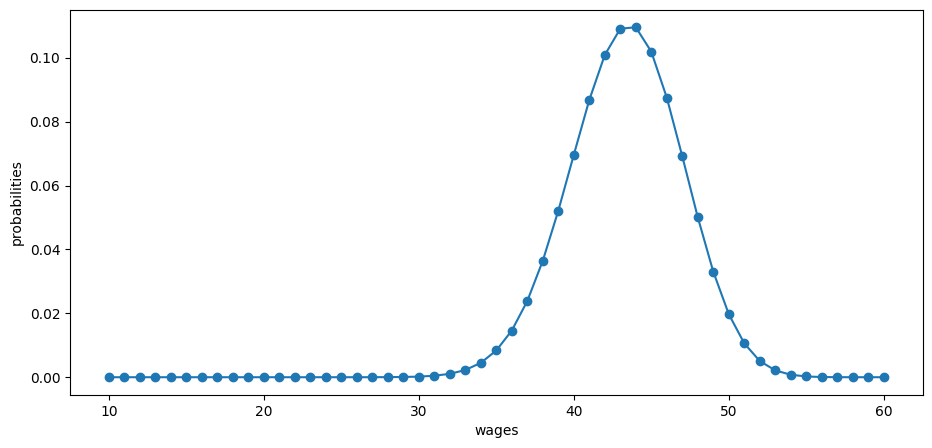

In [5]:
fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()


In [6]:
mccall_data = [
    ('c', float64), # unemployment compensation
    ('β', float64), # discount factor
    ('w', float64[:]), # array of wage values, w[i] = wage at state i
    ('q', float64[:]) # array of probabilities
] # provide type info for Numba class

In [7]:
@jitclass(mccall_data)
class McCallModel:
  def __init__(self, c=25, β=0.99, w=w_default, q=q_default):
    self.c, self.β = c, β
    self.w, self.q = w_default, q_default

  def state_action_values(self, i, v):
    """
    The values of state-action pairs.
    """
    # simplify names
    c, β, w, q = self.c, self.β, self.w, self.q
    # evaluate value for each state-action pair
    # consider action = accept or reject the current offer
    accept = w[i] / (1 - β) # there's one acceptance value
    reject = c + β * np.sum(v * q) # and a conditional mean rejection value

    return np.array([accept, reject])


In [8]:
def plot_value_function_seq(mcm, ax, num_plots = 7):
  """
  plot a sequence of value functions.
    * mcm is an instance of McCallModel
    * ax is an axes object that implements a plot method.
  """
  n = len(mcm.w)
  v = mcm.w /(1 - mcm.β)
  v_next = np.empty_like(v)
  for i in range(num_plots):
    ax.plot(mcm.w, v, '-', alpha=0.4, label =f"iterate{i}")
    # update guess
    for j in range(n):
      v_next[j] = np.max(mcm.state_action_values(j, v))
    v[:] = v_next

  ax.legend(loc='lower right')

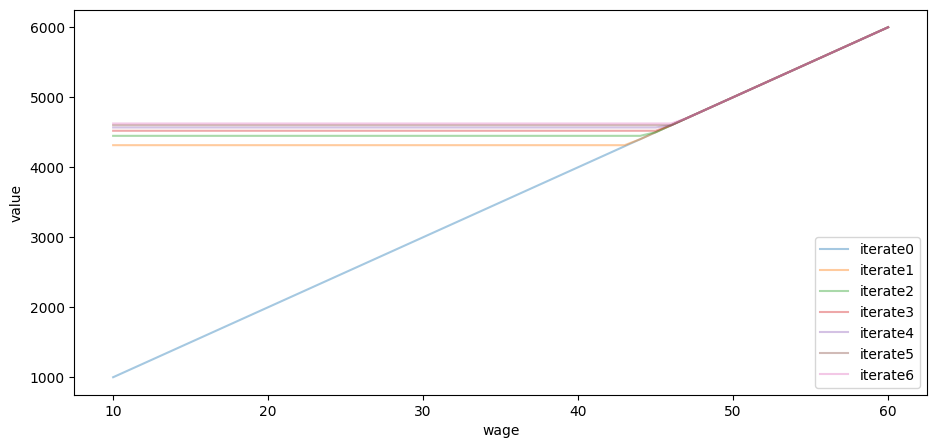

In [9]:
mvm = McCallModel()
fig, ax = plt.subplots()
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mvm, ax)
plt.show()

In [10]:
@jit
def compute_reservation_wage(mcm,
                             max_iter=500,
                             tol=1e-6):
  # Simplify names
  c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q
  # == First compute the value function == #

  n = len(w)
  v = w / (1 - β) # initial guess
  v_next = np.empty_like(v)
  j = 0
  error = tol + 1
  while j < max_iter and error > tol:
    for j in range(n):
      v_next[j] = np.max(mcm.state_action_values(j,v))
    error = np.max(np.abs(v_next - v))
    j += 1

    v[:] = v_next
  # == Now compute the reservation wage == #

  return (1 - β) * (c + β * np.sum(v*q))

In [11]:
compute_reservation_wage(mvm)

47.316499710024964

In [12]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
  for j, β in enumerate(β_vals):
    mcm = McCallModel(c=c, β=β)
    R[i, j] = compute_reservation_wage(mcm)

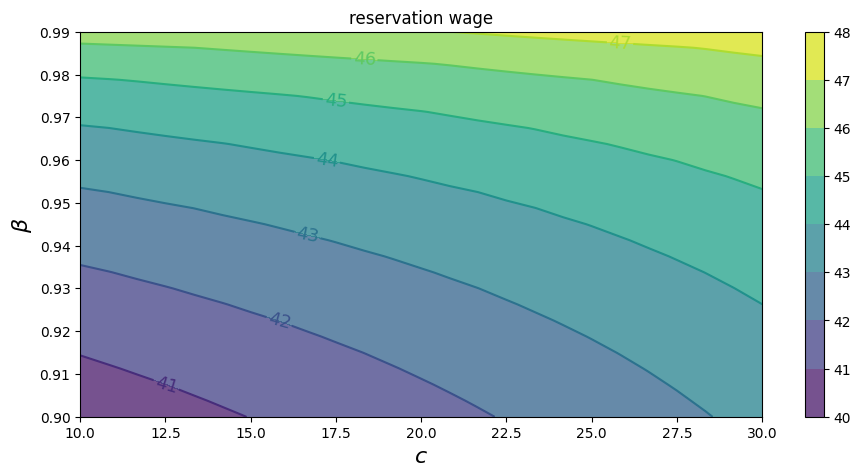

In [13]:
fig, ax = plt.subplots()
cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline = 1, fontsize=13)
plt.colorbar(cs1, ax=ax)

ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)
ax.ticklabel_format(useOffset=False)
plt.show()


In [14]:
def compute_reservation_wage_two(mcm, max_iter=500, tol=1e-5):
  # Simplify names
  c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q
  # == First compute h == #
  h = np.sum(w*q)/(1-β)

  i = 0
  error = tol + 1
  while i < max_iter and error > tol:
    s = np.maximum(w/(1-β),h)
    h_next = c + β * np.sum(s * q)

    error = np.abs(h_next - h)
    i += 1
    h = h_next

  return (1 - β) * h

In [15]:
compute_reservation_wage_two(mvm)

np.float64(47.316499166392845)

In [16]:
np.isclose(compute_reservation_wage(mvm), compute_reservation_wage_two(mvm))

np.True_

In [17]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
  for j, β in enumerate(β_vals):
    mcm = McCallModel(c=c, β=β)
    R[i, j] = compute_reservation_wage_two(mcm)

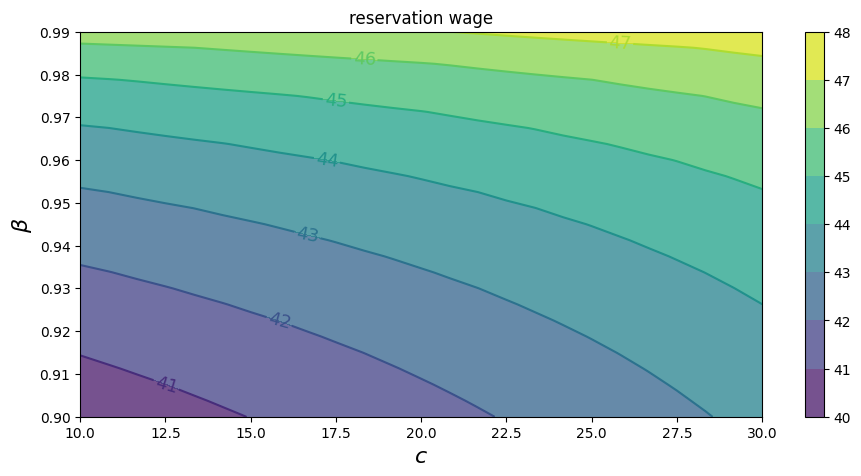

In [18]:
fig, ax = plt.subplots()
cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline = 1, fontsize=13)
plt.colorbar(cs1, ax=ax)

ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)
ax.ticklabel_format(useOffset=False)
plt.show()


Ex 27.1

In [19]:
# find the timings

c_vals = np.linspace(10.0, 40.0, grid_size)
cumulated = np.cumsum(q_default)

@jit
def draw_q():
  u = np.random.uniform()
  pr_d = u - cumulated
  pr_d[pr_d < 0] = 999

  return w_default[np.argmin(pr_d)]

def multi_q(N:int)->np.array:
  return np.asarray([draw_q() for x in range (N)])

@jit
def simfunc(rw:float):
  record = 0
  q = 0
  while q < rw:
    record += 1
    q = draw_q()


  return record

R = np.empty_like(c_vals)
Prs = np.empty_like(R)
times = np.empty_like(R)
emp_pr = np.empty_like(times)
for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c, β=0.99)
    R[i] = compute_reservation_wage_two(mcm)
    wage_D = R[i] - w_default
    wage_D[wage_D < 0] = 999
    Prs[i] = q_default[np.argmin(wage_D)]
    times[i] = 1/Prs[i]
    z = [simfunc(R[i]) for y in range(499)]
    emp_pr[i] = np.mean(z)



# two approaches --> find Pr := Q(reservation_wage); get 1/P
# or simulate



Text(0, 0.5, 'SEARCH TIME')

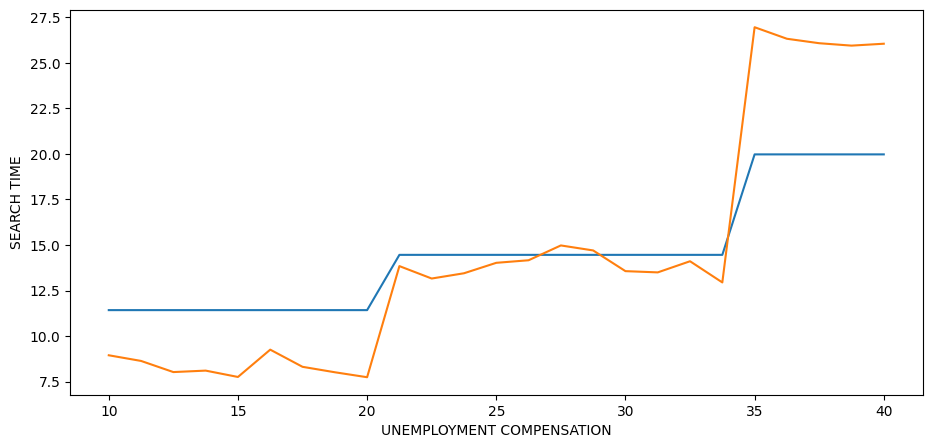

In [20]:
fig, ax = plt.subplots(1,1)
ax.plot(c_vals,times)
ax.plot(c_vals,emp_pr)
ax.set_xlabel('UNEMPLOYMENT COMPENSATION')
ax.set_ylabel('SEARCH TIME')


Text(0, 0.5, 'SEARCH TIME')

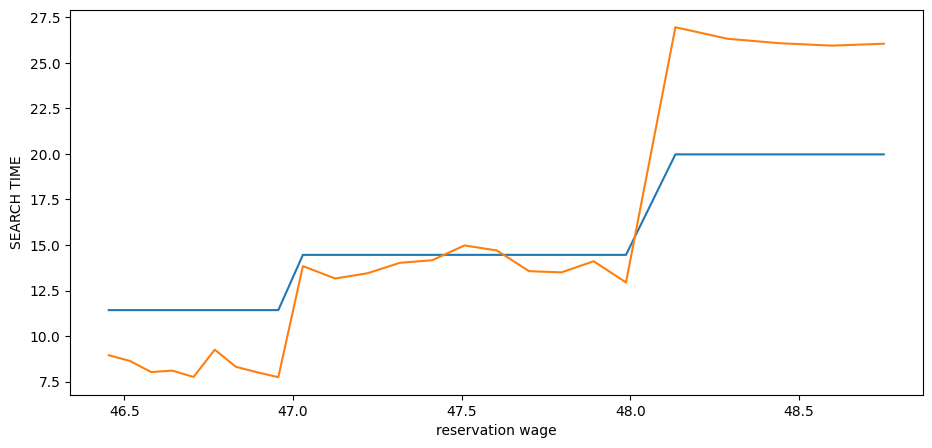

In [21]:
fig, ax = plt.subplots(1,1)
ax.plot(R,times)
ax.plot(R,emp_pr)
ax.set_xlabel('reservation wage')
ax.set_ylabel('SEARCH TIME')


In [22]:
def cbell_accept(β=0.99, mu=2.5, S=None, sigma=0.5):
  acc_val = np.exp(mu + sigma * S)/(1 - β)
  return acc_val


In [23]:

def cs_state_action_values(s_val=None, v_vals=None, c=25., β=0.99,mu=2.5,
                         sigma=0.5):
  # h = c + beta * (Integrate v(s')*q(s')) over s')
  # use the fixed point theory

  # random normal draw
  s_val = norm().rvs(1) if s_val == None else s_val

  # weights for averaging
  # let's convert v-vals to z scores
  z_vals = (v_vals - np.mean(v_vals))/np.std(v_vals)

  probs = norm().pdf(x=z_vals)
  print(np.mean(v_vals))
  w_val = np.exp(mu + sigma * s_val)/(1 - β)
  h =  c + β * np.sum(np.convolve(probs, v_vals) )
  return np.array([w_val.item(), h])


In [24]:
norm().cdf(.51)

np.float64(0.6949742691024806)

In [25]:
cs_state_action_values(v_vals= 40+ 10*norm().rvs(50))

39.1984820548273


array([ 1168.60860435, 27009.78622348])

In [26]:
def mccall_states(sample_size=1999, β=0.99,mu=2.5, sigma=0.5):
  generated_states = norm().rvs(sample_size)
  generated_states = np.sort(generated_states)
  generated_p_vals = norm().pdf(generated_states)
  generated_p_vals = generated_p_vals /np.sum(generated_p_vals)
  wages =  np.exp(mu + sigma * generated_states)/(1 - β)
  return {'states':generated_states, 'pvals':generated_p_vals, 'wages':wages}

mccall_states()

In [69]:
def update_v(s_vals=None, p_vals=None, v_vals=None, w_vals=None, c=25., β=0.99):
  # function that takes a
  h = c + β * np.dot(p_vals, v_vals)
  h_vec = h * np.ones_like(w_vals)
  #v_star = np.array([z for z in starmap(lambda x,y: max([x,y]), zip(w_vals, h_vec))])
  v_star = np.maximum(w_vals, h)
  h_prime = c + (β * np.dot(p_vals, v_star))
  return {'h':h, 'v_star':v_star, 'h_prime': h_prime }



In [81]:
def run_normal_sim(sample_size=1999, β=0.99,mu=2.5, sigma=0.5, c=25., tol=1e-2,
                   plot = False):
  if plot:
    fig, ax = plt.subplots()
    ax.set_xlabel('wage')
    ax.set_ylabel('value')

  aone = mccall_states(sample_size=sample_size, β=β,mu=mu, sigma=sigma)
  atwo = update_v(s_vals = aone['states'], p_vals=aone['pvals'],
                  v_vals=aone['wages'],
                  w_vals=aone['wages'],c=c, β=β)
  counter = 0
  while abs(atwo['h'] - atwo['h_prime']) >  tol:
    athree = update_v(s_vals = aone['states'], p_vals=aone['pvals'],
                      v_vals=atwo['v_star'],
                      w_vals=aone['wages'], c=c, β=β)
    atwo.update(athree)
    counter += 1
    if plot and (counter % 41 == 0):
      ax.plot(aone['wages']*(1-β), atwo['v_star']*(1-β), '-', alpha=0.4, label =f"iterate{counter}")
  else:
    if plot:
      plt.show()
      plt.plot(aone['wages'].ravel()*(1-β), '-', alpha=0.4, label ="True Wage")
      plt.plot(atwo['v_star'].ravel()*(1-β), '-', alpha=0.4, label ="V-star")
      plt.legend()
      plt.show()
      plt.close()

    return {'aone':aone, 'atwo': atwo}

In [82]:
def simulate_comparative_statics(  grid_size = 25, c_min=10., c_max=35., β_min=0.88, β_max=0.99):

  R = np.empty((grid_size, grid_size))

  c_vals = np.linspace(c_min, c_max, grid_size)
  β_vals = np.linspace(β_min, β_max, grid_size)

  for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
      mcm_sim = run_normal_sim(β=β, c=c)
      R[i, j] = mcm_sim['atwo']['h']*(1-β)
  fig, ax = plt.subplots()
  cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
  ctr1 = ax.contour(c_vals, β_vals, R.T)

  plt.clabel(ctr1, inline = 1, fontsize=13)
  plt.colorbar(cs1, ax=ax)

  ax.set_title("reservation wage")
  ax.set_xlabel("$c$", fontsize=16)
  ax.set_ylabel("$β$", fontsize=16)
  ax.ticklabel_format(useOffset=False)
  plt.show()
  plt.close()
  return {'R':R, 'c_vals':c_vals, 'β_vals':β_vals}

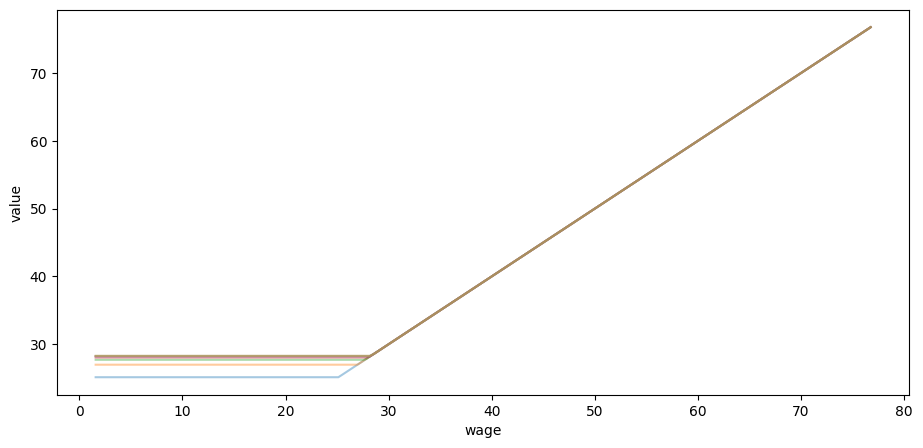

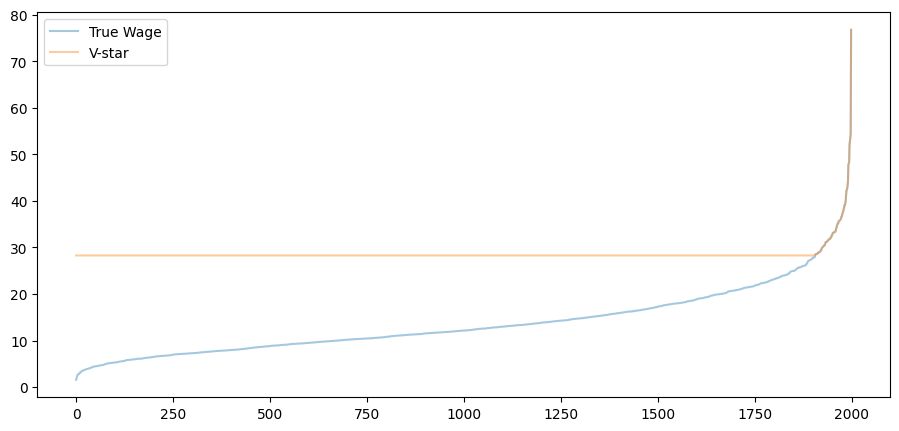

{'aone': {'states': array([-4.08817404, -3.71145269, -3.53303941, ...,  2.96292208,
          2.99489296,  3.6810134 ]),
  'pvals': array([1.66157963e-07, 7.22040963e-07, 1.37793142e-06, ...,
         8.77857002e-06, 7.98109179e-06, 8.08024666e-07]),
  'wages': array([ 157.76130534,  190.46031252,  208.23150818, ..., 5359.52817748,
         5445.89104137, 7674.64169606])},
 'atwo': {'h': np.float64(2827.8066109797196),
  'v_star': array([2827.80661098, 2827.80661098, 2827.80661098, ..., 5359.52817748,
         5445.89104137, 7674.64169606]),
  'h_prime': np.float64(2827.8165258201157)}}

In [83]:
run_normal_sim(plot=True)

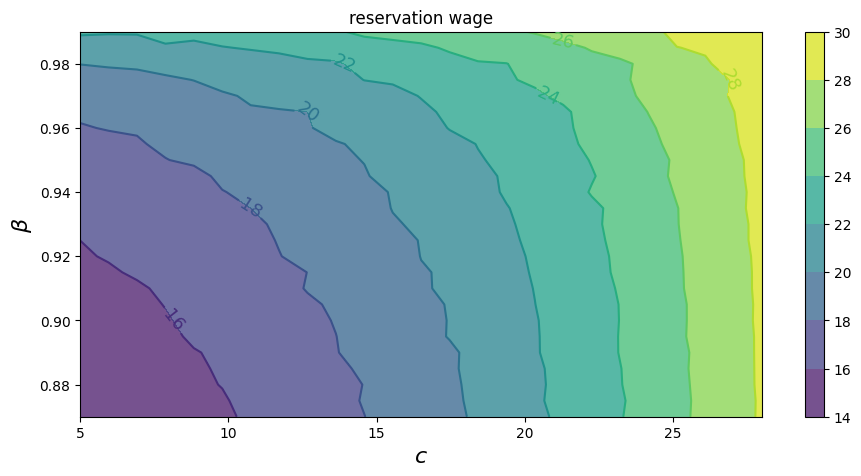

{'R': array([[14.27849533, 14.35993694, 14.40012769, 14.51432567, 14.58173299,
         14.92841684, 14.83512356, 15.1946798 , 15.29322995, 15.46592631,
         15.8234196 , 16.00305627, 16.10245334, 16.13298549, 16.34991517,
         16.94674   , 17.06864049, 17.6431489 , 17.86015836, 18.31495213,
         18.86919006, 19.30007283, 20.02958905, 20.83409259, 22.34137501],
        [14.6183242 , 14.39100519, 14.55768694, 14.94671391, 14.85390537,
         15.33772171, 15.33408825, 15.51546043, 15.73402159, 15.80419029,
         16.12300655, 16.16967661, 16.18337492, 16.60262427, 16.86291048,
         16.95008445, 17.38794372, 17.49371397, 18.1065435 , 18.64381337,
         19.02823053, 19.41475512, 20.17014234, 20.71290502, 22.24617056],
        [14.67639669, 14.77888896, 14.85867114, 15.21519349, 15.26077173,
         15.50308992, 15.46497844, 15.69785113, 15.77872875, 16.20805846,
         16.40052003, 16.35944009, 16.68163968, 16.89355544, 17.10127896,
         17.36472979, 17.591236

In [90]:
simulate_comparative_statics(β_min=0.870, c_min = 5, c_max=28, grid_size=25)
#

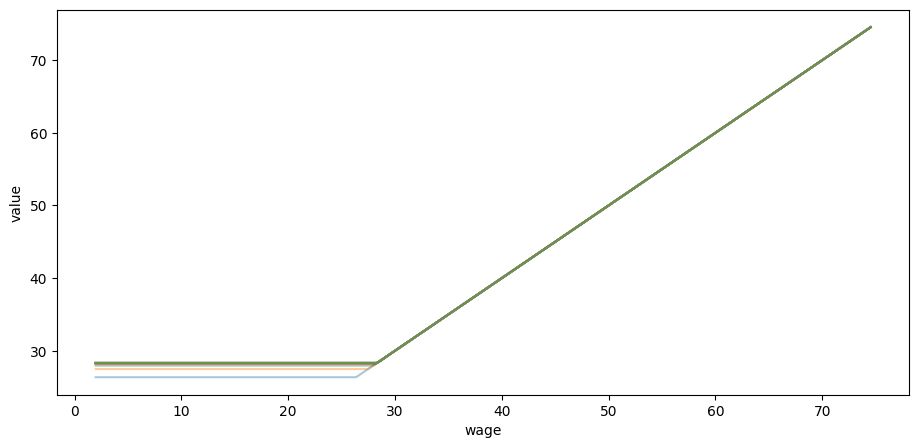

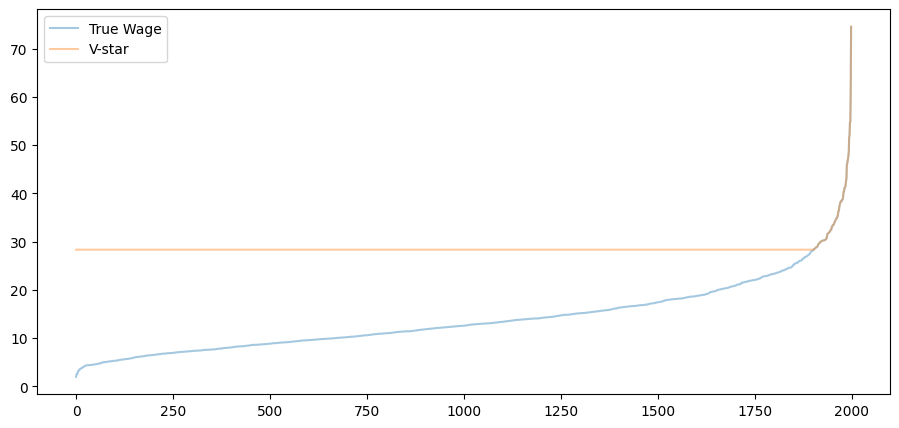

In [79]:
j = run_normal_sim(plot=True, tol=1e-7, c=1000)

(array([1.953e+03, 1.600e+01, 1.000e+01, 7.000e+00, 7.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([2803.50035197, 3153.93264347, 3504.36493496, 3854.79722645,
        4205.22951794, 4555.66180944, 4906.09410093, 5256.52639242,
        5606.95868392, 5957.39097541, 6307.8232669 ]),
 <BarContainer object of 10 artists>)

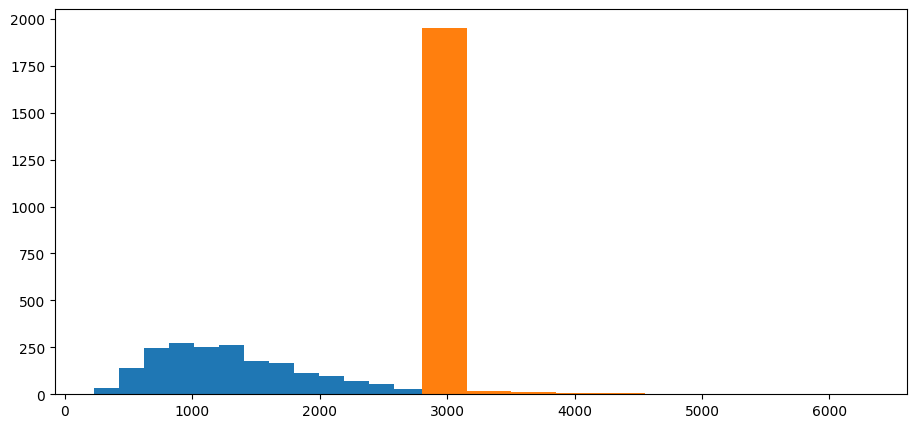

In [65]:
plt.hist(j['aone']['wages'], bins=31)
plt.hist(j['atwo']['v_star'])

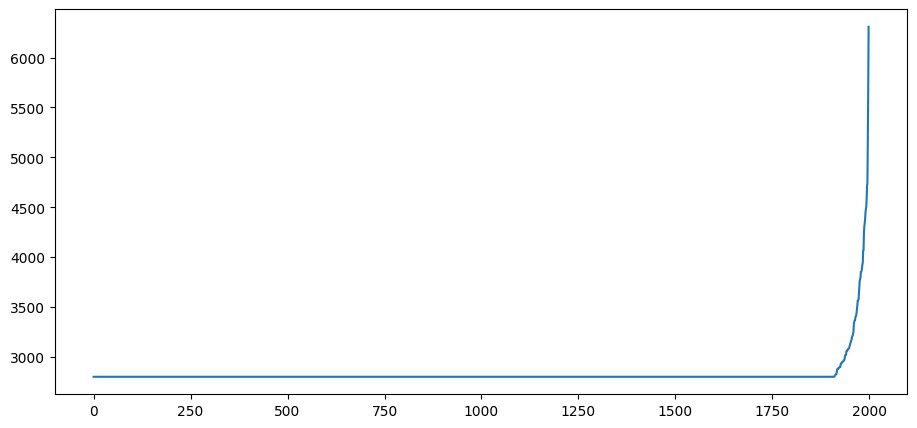

In [66]:
plt.plot(j['atwo']['v_star'])

In [39]:
mccall_data_continuous = [
    ('c', float64),          # unemployment compensation
    ('β', float64),          # discount factor
    ('σ', float64),          # scale parameter in lognormal distribution
    ('μ', float64),          # location parameter in lognormal distribution
    ('w_draws', float64[:])  # draws of wages for Monte Carlo
]

@jitclass(mccall_data_continuous)
class McCallModelContinuous:

    def __init__(self, c=25, β=0.99, σ=0.5, μ=2.5, mc_size=1000):

        self.c, self.β, self.σ, self.μ = c, β, σ, μ

        # Draw and store shocks
        np.random.seed(1234)
        s = np.random.randn(mc_size)
        self.w_draws = np.exp(μ+ σ * s)


@jit
def compute_reservation_wage_continuous(mcmc, max_iter=500, tol=1e-5):

    c, β, σ, μ, w_draws = mcmc.c, mcmc.β, mcmc.σ, mcmc.μ, mcmc.w_draws

    h = np.mean(w_draws) / (1 - β)  # initial guess
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        integral = np.mean(np.maximum(w_draws / (1 - β), h))
        h_next = c + β * integral

        error = np.abs(h_next - h)
        i += 1

        h = h_next

    # == Now compute the reservation wage == #

    return (1 - β) * h

In [40]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcmc = McCallModelContinuous(c=c, β=β)
        R[i, j] = compute_reservation_wage_continuous(mcmc)

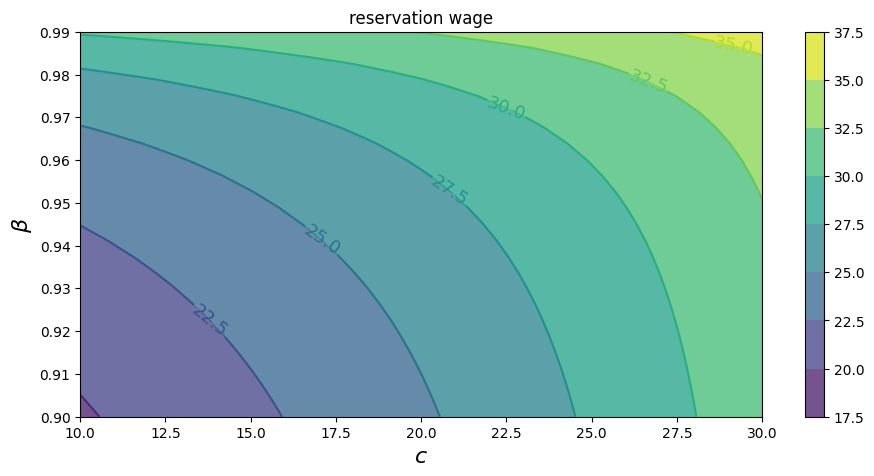

In [41]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

(array([ 24., 177., 289., 319., 284., 256., 171., 144.,  99.,  81.,  40.,
         29.,  24.,  18.,  10.,   6.,  10.,   5.,   1.,   3.,   3.,   1.,
          1.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 197.79753857,  424.50379001,  651.21004146,  877.9162929 ,
        1104.62254434, 1331.32879578, 1558.03504722, 1784.74129866,
        2011.4475501 , 2238.15380155, 2464.86005299, 2691.56630443,
        2918.27255587, 3144.97880731, 3371.68505875, 3598.39131019,
        3825.09756164, 4051.80381308, 4278.51006452, 4505.21631596,
        4731.9225674 , 4958.62881884, 5185.33507029, 5412.04132173,
        5638.74757317, 5865.45382461, 6092.16007605, 6318.86632749,
        6545.57257893, 6772.27883038, 6998.98508182, 7225.69133326,
        7452.3975847 ]),
 <BarContainer object of 32 artists>)

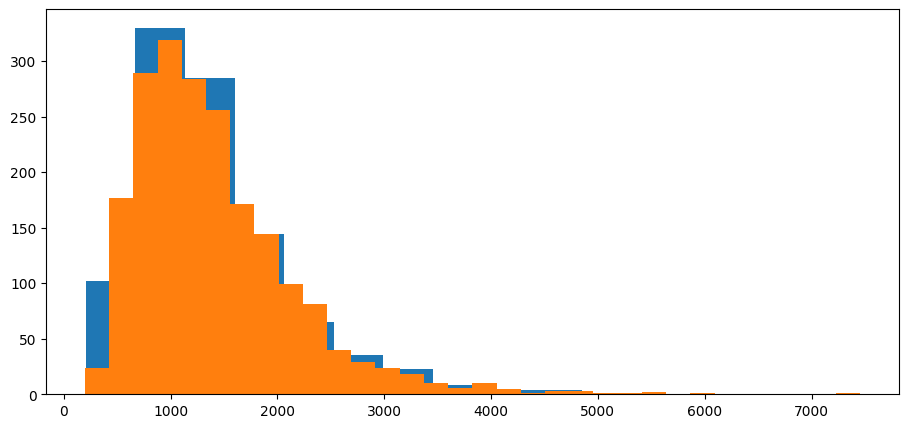

In [80]:

plt.hist(mcmc.w_draws/(1-β))
plt.hist(j['aone']['wages'],bins=32)

In [ ]:
plt.hist(j['aone']['wages']*(.01))

In [56]:
np.maximum(j['aone']['wages'] , 2267)

array([2267.        , 2267.        , 2267.        , ..., 5240.99086396,
       5394.59824771, 5494.20325959])